# Forecasting  Spain's Unemployment Rate
*Álvaro Rivera Arcelus*<br>
<br><br>
Forecasting  Spain's unemployment rate using the following Multivariate Forecasting Machine Learning algorithms:
<ul>
    <li>LSTM - Long Short Term Memory Neural Network</li>
    <li>Facebook Prophet</li>
<ul>

### Data sources <br>
We're going to use macroeconomic indicators from 1980 to 2020
<ul>
    <li>OECD iLibrary</li>
    <li>World Bank</li>
</ul>


### Features<br>
*(Factors that affect unemployment)*

<ul>
    <li>Annual Average Short-term interest rate</li>
    <li>Death rate</li>
    <li>Foreign DirectInvestment (net inflows)</li>
    <li>Fertility rate</li>
    <li>Infant mortality rate</li>
    <li>GDP growth rate</li>
    <li>Inflation rate</li> 
<ul>

### Evaluation metrics

We will evaluate our models via the **Root Mean Squared Error (RMSE)**

## Data Cleansing

In [43]:
#importing necesarry libraries 
import pandas as pd 
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
import datetime as dt

#Time Series Libraries 
import matplotlib.dates as mdates
%matplotlib inline
import statsmodels.api as sm
from keras.preprocessing.sequence import TimeseriesGenerator

#Tensor Flow for LSTM Forecasting
import tensorflow as tf

**Importing datasets**

In [44]:
#importing all datasets

#euro short-term interest rates 
interest = pd.read_csv('interest_rates_sp.csv' )
#murder rate 
death = pd.read_csv('murder_rate_sp.csv' )
#Foreign direct investment 
fdi = pd.read_csv('FDI_sp.csv')
#Fertility rate
fert = pd.read_csv('fertility_sp.csv' )
#Infant mortaliy rate 
infant = pd.read_csv('infant_mort_rate_sp.csv' )
#GDP 
gdp = pd.read_csv('gpd_growth_sp.csv' )
#inflation 
inf = pd.read_csv('cpi_sp.csv' )
#unemployment rate
unemp = pd.read_csv('unemployment_sp.csv' )

**Selecting only data of interest**

In [45]:
#filtering out data previous to year 2000 and from conutries different from Spain
set_df = [death,fdi,fert,infant,gdp,inf,unemp]

#cleaning interest df (OECD format not WorldBank)
interest.TIME = pd.to_datetime(interest.TIME, infer_datetime_format=True)
interest['Year'] = interest.TIME.dt.year
interest = interest[interest.LOCATION == 'ESP']
interest = interest[interest.Year >= 1980]
interest = interest[interest.Year < 2021]
interest = interest[['Year','Value','TIME']]

In [46]:
#calculating average annual interest rate
interest = interest.groupby(['Year']).mean()

In [47]:
#Concatenating all dataframes into a single one
main_df = pd.DataFrame(columns= inf.columns[24:65])
for i in set_df:
    p = i[i['Country Name'] == 'Spain']
    p = p.iloc[:,24:65]
    main_df = pd.concat([main_df,p])

#change data type of main_df columns to integer
main_df.columns = range(1980,2021)

#concatenate with interest rate data 
main_df = pd.concat([main_df, interest.transpose()]).reset_index(drop=True)

#creating new column with metrics and transposing back again
main_df['Metric'] = ['death','fdi','fert','infant','gdp','inf','unemp','interest']
main_df = main_df.set_index('Metric').transpose()
#changing datatypes of all variables in dataframe
main_df = main_df.astype('float64')
main_df.head()

Metric,death,fdi,fert,infant,gdp,inf,unemp,interest
1980,7.7,1.492697e+09,2.22,12.4,2.208728,15.561902,11.40,16.144796
1981,7.8,1.706767e+09,2.04,11.5,-0.132469,14.549346,14.17,16.177664
1982,7.5,1.782685e+09,1.94,10.8,1.246462,14.415002,16.00,16.281498
1983,7.9,1.622389e+09,1.80,10.1,1.770116,12.174073,17.49,20.049574
1984,7.8,1.771830e+09,1.73,9.6,1.784688,11.280277,20.25,14.897829


## Exploratory Data Analysis

**Evolution of Macroeconomic Metrics**

From the following graph, we can get to the following conclusions: 
*   Most of the metrics have sudden changes at the end the year 2019. Definitely caused by the Covid-19 outbreak. 
*   Unemployment rate has three main peaks in 1985,1995 and 2014 whith a notorious trough from 2000  to 2006
*   Eventhough interest rates have been constantly decreasing over the past 40 years, inflation has also seen a sharp decline. (Not applicable for year 2022 where the effect of the monetary expansionary policies taken by the European Union are starting to show bold signs of inflation)

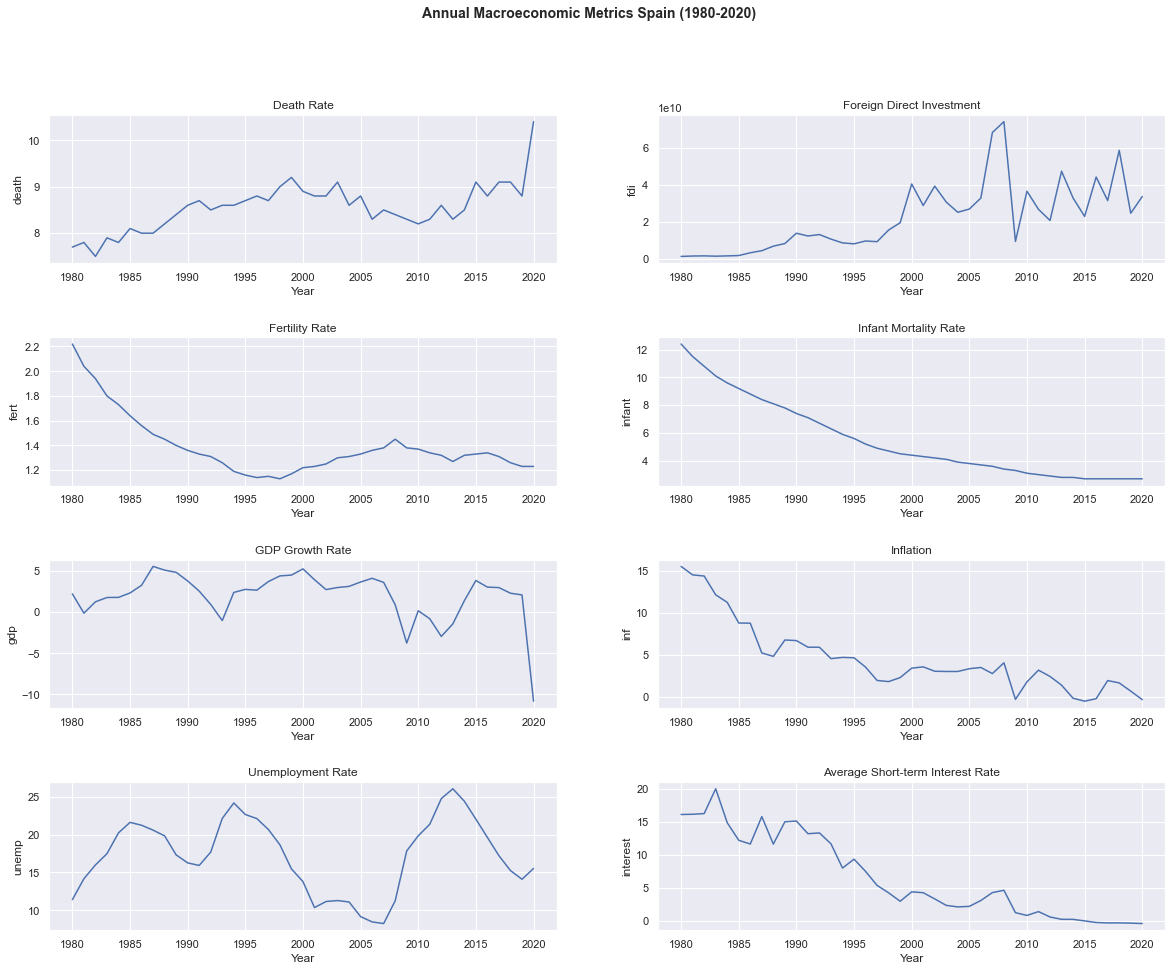

In [48]:
fig, ax = plt.subplots(4,2, sharex=False, sharey=False, figsize=(20,15))
fig.set_facecolor('white')
#adding space between subplots
fig.subplots_adjust(hspace=0.5)

fig.suptitle('Annual Macroeconomic Metrics Spain (1980-2020)', size=14, weight='bold')
titles=['Death Rate','Foreign Direct Investment','Fertility Rate','Infant Mortality Rate','GDP Growth Rate','Inflation','Unemployment Rate','Average Short-term Interest Rate']
pos =0 
for i in range(0,4):
    for j in range(0,2):
        ax[i,j].plot(main_df.index, main_df.iloc[:,pos])
        ax[i,j].set_ylabel(main_df.columns[pos])
        ax[i,j].set_title(titles[pos])
        ax[i,j].set_xlabel('Year')
        pos +=1

**Correlation Matrix**

The heatmap below shows the correlation between all variables (features) in our dataset. <br>
We can see obvious correlations between variables such as *inflation* and *interest rates* or even *fertility* and *infant mortality rate*.<br>
Nevertheless it is important to always **recall that** Correlation $\neq$ Causation

[Text(0.5, 1.0, 'Correlation Heatmap')]

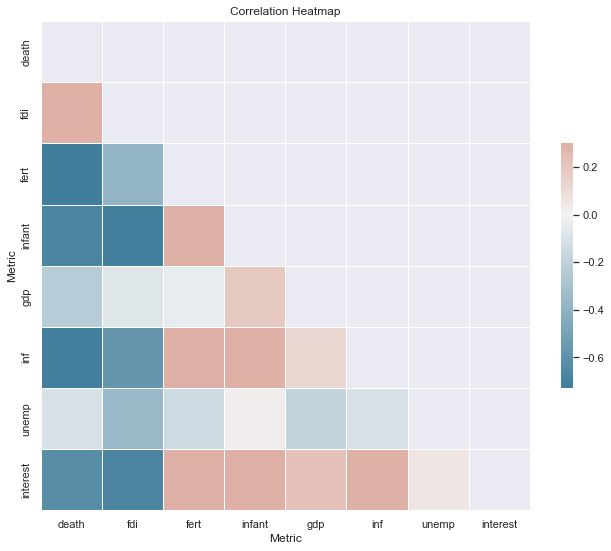

In [49]:
corr = main_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white', "figure.figsize":(14, 6)})
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set(title='Correlation Heatmap')

## Data Preprocessing

Given the quality of the data we're using and the types of variables  we have, there is not need for any data preprocessing process such as *Feature Engineering*,*Mean imputation* or *Encoding*

Nevertheless, we will require to use a correlation matrix as our method for **feature selection**

### Feature Selection

**Note:** it's insightful to see that the variable with the lowest correlation with unemployment rate is *short-term interest rate*. (Completely against Phillips Curve Theory)

In [50]:
#selecting feature whose correlation with the target variable is greater than 0.1 
#this removes only one feature --> interest
corr[abs(corr['unemp'])>0.1].unemp

Metric
death   -0.110891
fdi     -0.359949
fert    -0.149657
gdp     -0.196032
inf     -0.111079
unemp    1.000000
Name: unemp, dtype: float64

In [51]:
#new df for modelling 
df_train = main_df.drop(['interest'], axis=1)
#rearranging columns 
df_train = df_train[['unemp','death', 'fdi', 'fert', 'infant', 'gdp', 'inf']]

### Feature Scaling

In [52]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_train)
df_trains_scale = scaler.transform(df_train)

## Model Selection

We will be applying **Multi-Step Forecasting** with LSTM network

### LSTM Neural Network

In [53]:
#extracting training dates as a series object for future model performance evaluation
train_dates = pd.to_datetime(main_df.index, format='%Y')
train_dates

DatetimeIndex(['1980-01-01', '1981-01-01', '1982-01-01', '1983-01-01',
               '1984-01-01', '1985-01-01', '1986-01-01', '1987-01-01',
               '1988-01-01', '1989-01-01', '1990-01-01', '1991-01-01',
               '1992-01-01', '1993-01-01', '1994-01-01', '1995-01-01',
               '1996-01-01', '1997-01-01', '1998-01-01', '1999-01-01',
               '2000-01-01', '2001-01-01', '2002-01-01', '2003-01-01',
               '2004-01-01', '2005-01-01', '2006-01-01', '2007-01-01',
               '2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01',
               '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
               '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01',
               '2020-01-01'],
              dtype='datetime64[ns]', freq=None)

In [54]:
from keras.models import Sequential 
from keras.layers import LSTM
from keras.layers import Dense, Dropout

#we need a training set of feaures X and a training set for the target variable Y 
train_x=[]
train_y=[]

#we are telling the computer to go from timeframe 1 to 14 (X) and predict 15 (Y)
#next iteration... 2 to 15 (X) and predict 16 (Y) 
n_future=1
n_past=14

for i in range(n_past, len(df_trains_scale)-n_future+1):
    train_x.append(df_trains_scale[i - n_past:i, 0:df_train.shape[1]])
    train_y.append(df_trains_scale[i + n_future -1:i + n_future, 0])

train_x, train_y = np.array(train_x), np.array(train_y)

#14 means  the 14 days we're looking back to, and 7 the number of features we're using

#train_X is a hypermatrix of 27x7 with 14 layers 
print('train X shape == {}.'.format(train_x.shape))
print('train y shape == {}.'.format(train_y.shape))


train X shape == (27, 14, 7).
train y shape == (27, 1).


Setting up Neural Network

In [55]:
model = Sequential()
#64 units with a 14x7 matrix
#we add return sequences so that the output  of the first LSTM can be used as input fot the second LSTM

#LAYER 1
model.add(LSTM(64, activation='relu', input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
#LAYER 2
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(train_y.shape[1]))

Compiling Model<br>
*We define our loss function as the MSE of our prediction. (Function we wish to minimize)*

In [56]:
#we want to minimize the loss function MSE by using the optimizer 'adam'
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 14, 64)            18432     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,881
Trainable params: 30,881
Non-trainable params: 0
_________________________________________________________________


Fitting model

**Model Performance**<br>
*   ***Validation Loss*** : Error of deep learning model on the validation set
*   ***Training Loss*** : Error of deep learning model on the training set
<br>

*   If *validation loss* > *training loss* $\rightarrow$ **overfitting** (model is picking up the noise)
*   If *validation loss* < *training loss* $\rightarrow$ **undefitting** (model is not able to explain the data correctly)
    *   *Solution underfitting #1:* train the model more times, more epochs
    *   *Solution underfitting #2:* increase size of the data set

Epoch 1/10
2/2 [==============================] - 2s 219ms/step - loss: 1.3918 - val_loss: 0.5745
Epoch 2/10
2/2 [==============================] - 0s 22ms/step - loss: 1.3296 - val_loss: 0.6249
Epoch 3/10
2/2 [==============================] - 0s 22ms/step - loss: 1.2768 - val_loss: 0.6779
Epoch 4/10
2/2 [==============================] - 0s 21ms/step - loss: 1.2137 - val_loss: 0.7469
Epoch 5/10
2/2 [==============================] - 0s 22ms/step - loss: 1.1050 - val_loss: 0.8238
Epoch 6/10
2/2 [==============================] - 0s 22ms/step - loss: 1.0775 - val_loss: 0.9269
Epoch 7/10
2/2 [==============================] - 0s 21ms/step - loss: 0.9452 - val_loss: 1.0801
Epoch 8/10
2/2 [==============================] - 0s 22ms/step - loss: 0.8468 - val_loss: 1.2270
Epoch 9/10
2/2 [==============================] - 0s 22ms/step - loss: 0.8812 - val_loss: 1.2096
Epoch 10/10
2/2 [==============================] - 0s 22ms/step - loss: 0.7389 - val_loss: 1.0805


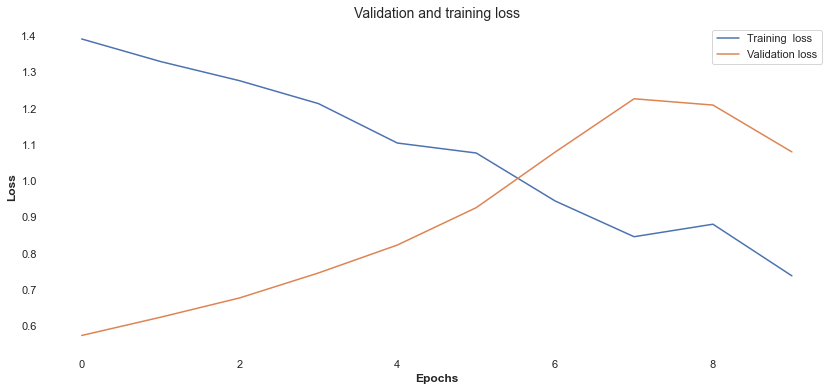

In [57]:
#we'll train the model 10 times (10 epochs)
#we use 10 epochs because we can see in the graph how 10 epochs minimizes the loss of the model 
#while also giving preventing over or underfitting
history = model.fit(train_x, train_y, epochs=10, batch_size=16, validation_split=0.1, verbose=1)
plt.plot(history.history['loss'], label='Training  loss')
plt.title('Validation and training loss', size=14)
plt.ylabel('Loss', weight='bold')
plt.xlabel('Epochs', weight='bold')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.grid()
plt.legend()
plt.show()

**Forecasting**

In [58]:
n_periods = 5
#creating timestamp with dates we want to predict
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_periods, freq='1y').tolist()
forecast = model.predict(train_x[-n_periods:])

1/1 [==============================] - 0s 186ms/step


In [59]:
model.predict(train_x[n_periods:])

1/1 [==============================] - 0s 15ms/step


array([[-0.32225168],
       [-0.45389515],
       [-0.54069763],
       [-0.58436143],
       [-0.59865415],
       [-0.59246147],
       [-0.56822014],
       [-0.53777635],
       [-0.49341315],
       [-0.3975373 ],
       [-0.2380508 ],
       [-0.03075149],
       [ 0.17575511],
       [ 0.37086105],
       [ 0.56588435],
       [ 0.74044806],
       [ 0.8427184 ],
       [ 0.8274139 ],
       [ 0.7564819 ],
       [ 0.6481589 ],
       [ 0.53642344],
       [ 0.43390104]], dtype=float32)

In [60]:
#scaling values to original scale
forecast_cop = np.repeat(forecast, df_train.shape[1], axis=1)
y_pred = scaler.inverse_transform(forecast_cop)[:,0]
#final forecast
y_pred

array([21.254646, 20.914808, 20.395832, 19.860504, 19.369318],
      dtype=float32)

**Visualizing results**

In [61]:
#converting timestamp to date
forecast_dates = []
for i in forecast_period_dates:
    forecast_dates.append(i.date())

#creating dataframe of forecasted values 
df_forecast = pd.DataFrame({'Year':np.array(forecast_dates), 'unemp':y_pred})
#set correct datetime format 
df_forecast['Year'] = pd.to_datetime(df_forecast.Year, infer_datetime_format=True)

#set dataset with original data 
original = main_df['unemp'].reset_index().rename(columns={'index':'Year'})
original['Year'] = pd.to_datetime(original['Year'], format='%Y')

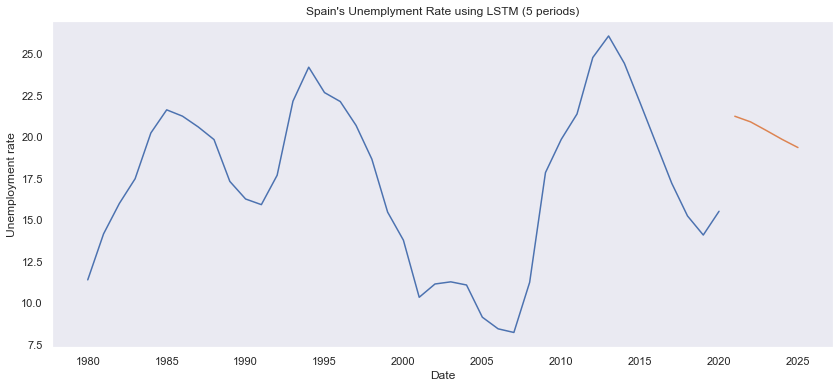

In [82]:
sns.lineplot(x=original['Year'], y= original.unemp).set(title="Spain's Unemplyment Rate using LSTM (5 periods)")
sns.lineplot(x=df_forecast['Year'], y=df_forecast['unemp'])
sns.set_style('darkgrid')
plt.xlabel('Date')
plt.ylabel('Unemployment rate')
plt.grid()

In [63]:
df_forecast

,Year,unemp
0,2020-12-31,21.254646
1,2021-12-31,20.914808
2,2022-12-31,20.395832
3,2023-12-31,19.860504
4,2024-12-31,19.369318


**Model Performance**<br>
*evaluate()* method from tensor wich measures de loss of our model. (RMSE)

In [64]:
results = model.evaluate(train_x, train_y, verbose=0)
print("Train loss: ", results)
#our validation function was MSE --> sqrt(MSE) = RMSE
print("RMSE: " +str(np.sqrt(results)))

Train loss:  0.6407830119132996
RMSE: 0.800489232852822


________________________

### Facebook Prophet

We are going to forecast every single regressor and then apply our results to the final model to forcast our target variable "Unemployment"<br>
This unconventional process may cause less accurate results as there will be errors within everty forecast we make for every regressor. 

In [65]:
from prophet import Prophet

In [66]:
#changing time and target variable names for FB Prophet algorithm
df_train = df_train.reset_index().rename(columns={'index':'ds','unemp':'y'})

In [67]:
#changing date format to date variable 
df_train['ds']=pd.to_datetime(df_train.ds, format='%Y')

In [68]:
df_train.iloc[-1,:]

Metric
ds        2020-01-01 00:00:00
y                       15.53
death                    10.4
fdi             33735353773.0
fert                     1.23
infant                    2.7
gdp                -10.822886
inf                 -0.322753
Name: 40, dtype: object

In [69]:
#forecasting every single regressor in the next 5 periods (5 years) using fbprophet 
#creating df with future periods 
future = pd.DataFrame()
future['ds'] = pd.date_range('2021-01-01',periods=5, freq='Y')

cols = ['death', 'fdi', 'fert', 'infant', 'gdp', 'inf']
regressor_pred = pd.DataFrame()

for metric in cols: 
    model = model = Prophet(interval_width=0.9)
    data = df_train[['ds',metric]].rename(columns={metric:'y'})
    model.fit(data)
    regressor_pred[metric] = model.predict(future)['yhat']

17:23:31 - cmdstanpy - INFO - Chain [1] start processing
17:23:31 - cmdstanpy - INFO - Chain [1] done processing
17:23:32 - cmdstanpy - INFO - Chain [1] start processing
17:23:32 - cmdstanpy - INFO - Chain [1] done processing
17:23:33 - cmdstanpy - INFO - Chain [1] start processing
17:23:33 - cmdstanpy - INFO - Chain [1] done processing
17:23:34 - cmdstanpy - INFO - Chain [1] start processing
17:23:34 - cmdstanpy - INFO - Chain [1] done processing
17:23:35 - cmdstanpy - INFO - Chain [1] start processing
17:23:35 - cmdstanpy - INFO - Chain [1] done processing
17:23:36 - cmdstanpy - INFO - Chain [1] start processing
17:23:36 - cmdstanpy - INFO - Chain [1] done processing


**Note** it's clear that the predictions the model makes aren't accurate as we are trying to forecast an economic metric which is affected by multiple other unpredictable factors. (For example: wars, reactions in financial markets, political decisions, etc.)

In [70]:
regressor_pred['ds'] = future
regressor_pred

,death,fdi,fert,infant,gdp,inf,ds
0,9.350880,5.146264e+10,1.316221,2.592069,-0.655349,-1.401166,2021-12-31
1,9.532653,5.360658e+10,1.363732,2.585266,-1.199619,-1.476451,2022-12-31
2,9.743304,5.564231e+10,1.424301,2.584491,-1.831960,-1.526287,2023-12-31
3,9.272816,5.371503e+10,1.233344,2.458463,-0.520776,-2.479514,2024-12-31
4,9.425412,5.596622e+10,1.267710,2.445532,-0.976226,-2.580575,2025-12-31


In [71]:
#Creating an instance of fb prophet 
model = Prophet(interval_width=0.9)
model.add_regressor('death', standardize=True)
model.add_regressor('fdi', standardize=True)
model.add_regressor('fert', standardize=True)
model.add_regressor('infant', standardize=True)
model.add_regressor('gdp', standardize=True)
model.add_regressor('inf', standardize=True)
model.fit(df_train)

17:23:37 - cmdstanpy - INFO - Chain [1] start processing
17:23:37 - cmdstanpy - INFO - Chain [1] done processing


In [72]:
df_test = df_train.loc[:, df_train.columns != 'y']
forecast_1 = model.predict(df_test)
forecast_1 = forecast_1[['ds','yhat']]
forecast_1.head()

,ds,yhat
0,1980-01-01,12.093895
1,1981-01-01,13.972523
2,1982-01-01,16.577561
3,1983-01-01,16.448457
4,1984-01-01,18.704716


In [73]:
#comparing predicted values vs true values 
final_pred = pd.concat((forecast_1.yhat, df_train), axis=1)
final_pred.head(3)

,yhat,ds,y,death,fdi,fert,infant,gdp,inf
0,12.093895,1980-01-01,11.40,7.7,1.492697e+09,2.22,12.4,2.208728,15.561902
1,13.972523,1981-01-01,14.17,7.8,1.706767e+09,2.04,11.5,-0.132469,14.549346
2,16.577561,1982-01-01,16.00,7.5,1.782685e+09,1.94,10.8,1.246462,14.415002


In [74]:
#calculating RMSE 
def rmse(df): return np.sqrt(sum((df.yhat - df.y)**2)/len(df))

metric_proph = round(rmse(final_pred),2)
print('----------'*2)
print('RMSE: ' + str(metric_proph))
print('MAE: ' + str(round((rmse(final_pred)**2),2)))
print('----------'*2)

--------------------
RMSE: 3.19
MAE: 10.16
--------------------


In [75]:
final_pred = model.predict(regressor_pred)
final_pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,death,...,infant,infant_lower,infant_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-12-31,28.860971,13.816410,24.280789,28.860971,28.860971,-9.620800,-9.620800,-9.620800,-6.610477,...,-11.899917,-11.899917,-11.899917,4.289008,4.289008,4.289008,0.0,0.0,0.0,19.240171
1,2022-12-31,29.524344,12.602443,23.040978,29.524344,29.524344,-11.896571,-11.896571,-11.896571,-8.108554,...,-11.927994,-11.927994,-11.927994,4.687608,4.687608,4.687608,0.0,0.0,0.0,17.627774
2,2023-12-31,30.187718,10.115340,20.851593,30.187717,30.187718,-14.682011,-14.682011,-14.682011,-9.844626,...,-11.931191,-11.931191,-11.931191,5.100293,5.100293,5.100293,0.0,0.0,0.0,15.505707
3,2024-12-31,30.852908,18.299936,28.884078,30.852908,30.852908,-7.234154,-7.234154,-7.234154,-5.967114,...,-12.451291,-12.451291,-12.451291,3.905010,3.905010,3.905010,0.0,0.0,0.0,23.618754
4,2025-12-31,31.516281,17.132450,27.646254,31.516281,31.516281,-8.996433,-8.996433,-8.996433,-7.224729,...,-12.504654,-12.504654,-12.504654,4.289008,4.289008,4.289008,0.0,0.0,0.0,22.519849


**Visualizing forecast**

In [76]:
#creating data frame with -1 periods for forecasted values (only for visualizarion pruposes)
df_graph = pd.DataFrame()
df_graph['ds'] = pd.to_datetime(['2020-01-01','2021-01-01','2022-01-01','2023-01-01','2024-01-01','2025-01-01',])
res = np.array(df_train.iloc[-1,1])
res = np.append(res, final_pred.yhat)
df_graph['y'] = res

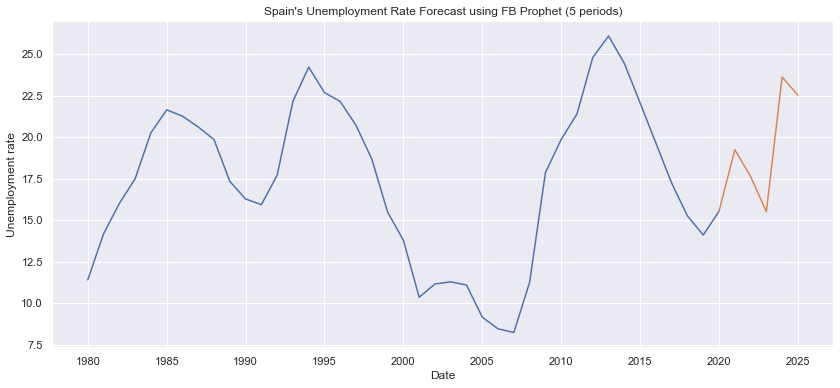

In [77]:
#graphng results using seaborn 
sns.lineplot(x=df_train['ds'], y=df_train['y']).set(title="Spain's Unemployment Rate Forecast using FB Prophet (5 periods)")
sns.lineplot(x=df_graph['ds'], y=df_graph['y'])
plt.ylabel('Unemployment rate')
plt.xlabel('Date')
plt.show()

## Conclusions

In [81]:
print('----------'*4)
print('RMSE (Facebook Prophet): ' + str(metric_proph))
print("RMSE (LSTM Neural Network): " +str(round(np.sqrt(results),2)))
print('----------'*4)

----------------------------------------
RMSE (Facebook Prophet): 3.19
RMSE (LSTM Neural Network): 0.8
----------------------------------------


We can clearly see how the **LSTM model performed better than the Facebook Prophet Model** based on their RMSE. <br>
Nevertheless, it is important to have into consideration the following points:
*   We have a small amount of observations for training our models adequately 
*   The LSTM model may perform differently depending on the distribution of observations of every training and valdation sets.
*   The FBProphet model is calculated by making individual time series  predictions for every regresssor. Which in turn, has large consequences on the accuracy of our model. (As it is seen with the difference on RMSE values)

## Resources 
*   https://data.oecd.org/interest/short-term-interest-rates.htm
*   https://data.worldbank.org/indicator/SP.DYN.IMRT.IN?end=2020&locations=ES&start=2001
*   https://data.worldbank.org/indicator/SP.DYN.CDRT.IN?end=2020&locations=ES&start=2001
*   https://data.worldbank.org/indicator/BX.KLT.DINV.CD.WD?end=2020&locations=ES&start=2001
*   https://data.worldbank.org/indicator/NY.GDP.MKTP.KD.ZG?end=2021&locations=ES&start=2001
*   https://data.worldbank.org/indicator/FP.CPI.TOTL.ZG?end=2021&locations=ES&start=2001



